In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy,mean_squared_error,mean_absolute_error
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
lenc = LabelEncoder()
ohe = OneHotEncoder()

In [2]:
N_CLASSES = 5
IMSIZE = (128,128,3)
INPUT_SIZE = 1000

In [3]:
def finetuned_inceptionresnet(include_top=False):
    base_model = InceptionResNetV2(include_top=include_top,input_shape=IMSIZE,weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)

    if not include_top:
        x = Dense(N_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(),loss=BinaryCrossentropy(from_logits=False),metrics=Accuracy())

    return model

In [4]:
Data = pd.read_csv("gestures.csv")


In [5]:
inception_model = finetuned_inceptionresnet()


2022-05-21 15:20:39.430110: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-21 15:20:39.430771: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (devil): /proc/driver/nvidia/version does not exist
2022-05-21 15:20:39.433319: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X,Y = np.array(Data.drop(columns="classes")).reshape(-1,128,128,3), ohe.fit_transform(np.array(Data.classes).reshape(-1,1)).toarray()
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.8)
del X,Y,Data


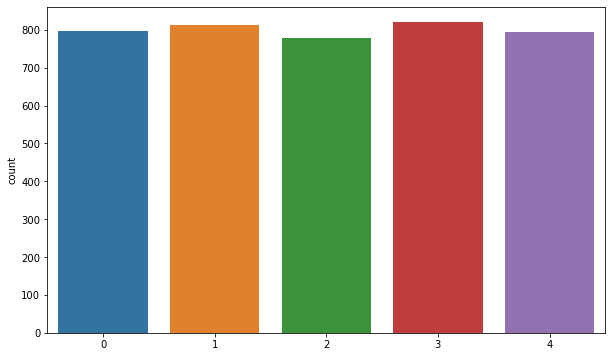

In [9]:
y = ohe.inverse_transform(ytrain)

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=y.flatten())
plt.show()

In [10]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
inception_model.fit(xtrain,ytrain,epochs=20,validation_split=0.2,batch_size=20)


Epoch 1/20


2022-05-20 16:30:33.875331: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.


160/160 [==============================] - 58s 336ms/step - loss: 0.1620 - accuracy: 0.0478 - val_loss: 0.1193 - val_accuracy: 0.0445
Epoch 2/20
160/160 [==============================] - 49s 308ms/step - loss: 0.0598 - accuracy: 0.0697 - val_loss: 0.0819 - val_accuracy: 0.0782
Epoch 3/20
160/160 [==============================] - 50s 310ms/step - loss: 0.0441 - accuracy: 0.0857 - val_loss: 0.0512 - val_accuracy: 0.0805
Epoch 4/20
160/160 [==============================] - 47s 294ms/step - loss: 0.0250 - accuracy: 0.1018 - val_loss: 0.0420 - val_accuracy: 0.1065
Epoch 5/20
160/160 [==============================] - 45s 280ms/step - loss: 0.0207 - accuracy: 0.1195 - val_loss: 0.0421 - val_accuracy: 0.1177
Epoch 6/20
160/160 [==============================] - 45s 280ms/step - loss: 0.0207 - accuracy: 0.1323 - val_loss: 0.0461 - val_accuracy: 0.1217
Epoch 7/20
160/160 [==============================] - 45s 280ms/step - loss: 0.0186 - accuracy: 0.1514 - val_loss: 0.0558 - val_accuracy: 0.1

In [ ]:
res = inception_model.predict(xtest).round(1)

In [ ]:
res_f = ohe.inverse_transform(res)
ytest_f = ohe.inverse_transform(ytest)

In [ ]:
print(classification_report(res_f,ytest_f))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       217
           1       0.97      0.97      0.97       197
           2       1.00      0.96      0.98       193
           3       0.97      0.97      0.97       192
           4       0.99      1.00      1.00       201

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



: 